In [30]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# function to find the key of the value when label encoding the classes
def key_find(classes, pred):
    for key, val in classes.items():
        if pred == val:
            return key
        
        
label_encoder = LabelEncoder()

# get data and instantiate Random Forest Classifier
X = pd.read_csv("/Users/kritinshanmugam/Desktop/gene_expression.csv")
y = pd.read_csv("/Users/kritinshanmugam/Desktop/label.csv")

# Handle missing values
X = X.dropna()
y = y.dropna()

# Drop ID column
X = X.iloc[:, 1:]

# Drop the first column of cell ID
y = y.iloc[:, 1:]

# Standardize features
X = (X - X.mean()) / X.std()

# Create copy of original (untransformed) y data to compare later with predictions
y_orig = y.copy()

In [31]:
from sklearn.model_selection import train_test_split

# Combine data sets for ease of splitting into train and test data sets
combined_XY = pd.concat([X, y], axis=1)

# One-hot encode the target variable
combined_XY['Annotation'] = label_encoder.fit_transform(combined_XY['Annotation'])

# Print the mapping between original classes and encoded integers
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Split the data into train and test sets
train, test = train_test_split(combined_XY, test_size=0.25, stratify=y['Time point'])

# Get the train/test data for the features
x_train = train.drop(columns=['Time point', 'Annotation'], axis=1)
x_test = test.drop(columns=['Time point', 'Annotation'], axis=1)

# Get the train/test data for the target 
y_train = train['Annotation']
y_test = test['Annotation']

In [32]:
# Train the random forest model
classifier = RandomForestClassifier(random_state=31)

classifier.fit(x_train, y_train)

# Obtain the predictions
y_predictions = classifier.predict(x_test)

# Convert predictions and test data to a Pandas Data Frame
y_predictions = pd.DataFrame(y_predictions)
y_test = pd.DataFrame(y_test)

# parameters for the model
params = {
    'n_estimators': [200, 600, 1_000, 1_400, 1_800],
    'max_depth': [3, 5, 7, 10, 13],
    'min_sample_split': [2, 5, 8, 11, 14, 17],
    'min_sample_leaf' : [2, 4, 6, 8],
    'max_features': [2, 4, 6, 8]
}


# Instantiate an empty dataframe to store the predictions in pre-transform format
predicted = pd.DataFrame({'predicted_class': []})

# Loop through the predictions and transform them back from the binary state
for prediction in y_predictions:
    class_pred = key_find(class_mapping, prediction)
    predicted.loc[len(predicted)] = class_pred

# Create list to store rows that have mispredicted cell types
incorrect_list = []


for row in range(len(y_predictions)):
    if y_predictions.iloc[row, 0] != y_test.iloc[row, 0]:
        incorrect_list.append(row)
        
print(incorrect_list)


[796, 2263]


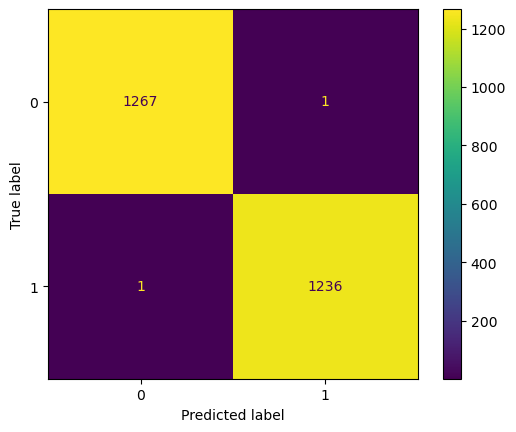

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Get the actual values and predicted values in array-like format
actual = y_test.values

predicted = y_predictions.values

# Generate a confusion matrix
confusion = confusion_matrix(actual, predicted, labels=classifier.classes_) 

# Generate display for confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=classifier.classes_)

display.plot()

In [43]:
import shap

explainer = shap.TreeExplainer(classifier, x_test)
shap_values = explainer(x_test)

for row in incorrect_list:
    shap.plots.waterfall(shap_values[row])


 99%|===================| 4971/5010 [01:08<00:00]        

2505
[796, 2263]


'\nfor row in incorrect_list:\n    shap.plots.waterfall(shap_values[row])\n'